# Submodular Package: First Demo
This a first demonstration of our submodular package.
In this demo, we will show how to 
1. Use our code to instantiate two classes of submodular functions: vertex cover and facility location.
2. Run the greedy algorithm and several faster variants on these submodular functions.
3. Use our code to instantiate certain matroids.
4. Run the continuous greedy algorithm on weighted vertex cover subject to partition matroid.

Let's begin by importing the `julia` files that contain our functions. Note that we are using the `Revise` package, which is very helpful for Jupyter notebooks.

*A fair warning: this notebook will use the current file names and locations. 
These are subject to change as the package grows.*

In [1]:
# import the algorithms code with revise
using Printf
using Revise
includet("../code_base/function_oracles.jl")
includet("../code_base/matroid_oracles.jl")
includet("../code_base/submodular_algs.jl")

# import package for plotting
using PyPlot

# Part 1: Creating a Submodular Function
How is a submodular function presented or represented? 
Let $V = \{ 1, 2, \dots n \}$ be a ground set and let $f: 2^V \rightarrow \mathbb{R}$ be a submodular set function. 
Note that the function is specified by $2^n$ values; however, storing all these values (let alone looking them up) would require exponential space and (perhaps) time.
For this reason, we assume that a submodular function is presented in the *value oracle model*, meaning that our algorithms have access to a function that takes a set $S$ as input and outputs the value $f(S)$.
This is the model that is used in the literature and, roughly speaking, this is the model that is accepted by the algorithms in our package.

The user can either define a submodular function or use a pre-specified one. At this time, we have two pre-specified functions: (1) weighted vertex cover and (2) facility location. Our algorithms all require only a *marginal gain value oracle* which is a function that takes a set $S$ and an element $e$ as input and outputs the marginal gain 
$$f( e \mid S) \triangleq f(S \cup e) - f(S)$$

### Part 1.1 Vertex Cover
Now, we show how to use one of our pre-built marginal gain functions for weighted vertex cover.
Given a graph $G = (V,E)$ with non-negative weights on the vertices (denoted $w_u$ for all $u \in V$), the *weighted vertex cover* function $f: 2^V \rightarrow \mathbb{R}$ is defined as 
$$ f(S) =  \sum_{u \in N(S)} w_u \enspace,$$
where $N(S) = \{ u \in V \mid u \in S \text{ or } u \text{ is adjacent to } S \}$ is the neighborhood set of $S$.

Our graphs for the weighted vertex cover will be specified by adjacency dictionaries. For our test example, we will consider the following graph: for each $r = 2, 3, \dots$ define $G_r$ as the disjoint union of complete graphs $K_2, K_3, \dots K_{r}$. This graph is nice because we can easily reason about the greedy algorithm and the constrained maximization problem.

Let's begin by creating the adjacency dictionary for this graph.

In [2]:
function create_graph_dict(r)
    # this function creates adjacency dictionary of disjoint complete graphs K_2, ... K_r
    
    # initialize to empty adjacency dictionary
    adj_dict = Dict{Int64, Set{Int64}}()
    
    next_v = 1
    for s=2:r
        
        # add the clique K_s to our adjacency dictionary
        this_clique = Set(next_v:(next_v + s - 1))
        for v in this_clique
           adj_dict[v] = setdiff(this_clique, v) 
        end
        
        # update for the next iteration
        next_v += s
    end
    return adj_dict
end

create_graph_dict (generic function with 1 method)

In [3]:
adj_dict = create_graph_dict(4)

Dict{Int64,Set{Int64}} with 9 entries:
  7 => Set([9, 8, 6])
  4 => Set([3, 5])
  9 => Set([7, 8, 6])
  2 => Set([1])
  3 => Set([4, 5])
  5 => Set([4, 3])
  8 => Set([7, 9, 6])
  6 => Set([7, 9, 8])
  1 => Set([2])

Great, so we see that the function produces the right adjacency dictionary. Now, let's see how to create a function which computes marginal gains. This funciton is included in the `function_oracles.jl` file.

In [4]:
f_diff(e, S) = weighted_vertex_cover_diff(e, S, adj_dict)

f_diff (generic function with 1 method)

In [5]:
f_diff(1, Set{Int64}())

2

In [6]:
f_diff(9, Set{Int64}())

4

In [7]:
f_diff(9, Set{Int64}([6,7,8]))

0

In [8]:
f_diff(4, Set{Int64}([6,7,8]))

3

Take a moment to verify for yourself that the above examples are correct. 


### Part 1.2 Facility Location
Now we discuss how to use our pre-built function for facility location. 
Let's begin with the relevant definitions.
Let $V = \{ 1, 2, \dots n \}$ be a ground set and let $s: V \times V \rightarrow \mathbb{R}_+$ be a non-negative similarity function. 
We define the facility location objective as
$$ f(S) = \frac{1}{n} \sum_{v \in V} \max_{u \in S} s(v,u) \enspace.$$

Our prebuilt function for facility location requires the user to specify a similarity function. 
We'll sample $n$ random points in $\mathbb{R}^2$ from a mixture of Gaussians and use a similiarity which is based on $\ell_2$ distance between vectors, i.e.
$$ s(x_i, x_j) = \frac{1}{1 + \| x_i - x_j \|^2 } $$

Let's begin by creating the mixture

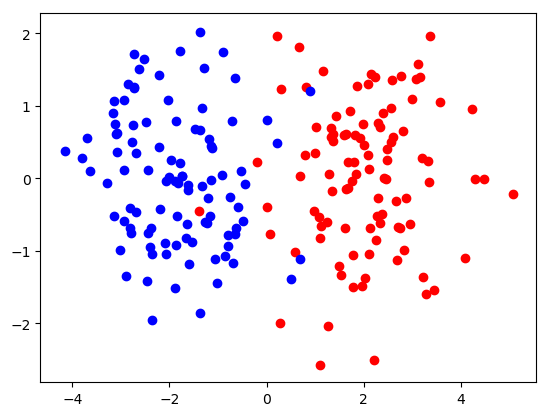

PyObject <matplotlib.collections.PathCollection object at 0x129fadc88>

In [9]:
# sample from a mixture of two gaussians
n_half = 100
n = 2*n_half
X = randn(2,n)
X[1, 1:n_half] += 2*ones(n_half) # centered at (1,0)
X[1, n_half+1:n] -= 2*ones(n_half) # centered at (-1,0)

# plot these points
scatter(X[1,1:n_half], X[2,1:n_half], c = "red")
scatter(X[1,n_half+1:n], X[2,n_half+1:n], c = "blue")

So that's what the points look like. 
Now let's code up the similarity score and use the built-in facility location function.

In [10]:
# create the similarity score
function similiarity(i,j,X)
    x = X[:,i]
    y = X[:,j]
    return 1. / (1 + (x - y)' * (x - y))
end

# use the built in function
sim(i,j) = similiarity(i,j,X)
f_diff(e,S) = facility_location_diff(e, S, n, sim)

f_diff (generic function with 1 method)

Now, let's verify that this function is submodular and also that we can see the two clusters in the marginal gain function `f_diff`

In [11]:
# adding a point in the same cluster as S
S = Set{Int64}([1,2])
f_diff(3, S)

0.07326675083615607

In [12]:
# adding a point in the different cluster as S
S = Set{Int64}([1,2])
f_diff(n, S)

0.1773659130280662

In [13]:
# increasing the set S, we should see diminishing returns
S = Set{Int64}([1,2,3,4])
f_diff(n, S)

0.17644041123514337

These results make sense. Take a moment to verify that they are doing what we think that they are doing.

## Part 2: Greedy Algorithm & Cardinality Constraint
In this section, we will show how to call the greedy algorithm (and several faster variants) using our package.
The code for the greedy algorithm (and the variants) is all contained in the file `submodular_algs.jl`.

### 2.1 The Vanilla Greedy Algorithm
First, let's review how to use the vanilla greedy algorithm. We'll do this on the vertex cover example that we have right now. Let's set $k=2$.

In [14]:
# create the weighted vertex cover objective
adj_dict = create_graph_dict(4)
n = length(adj_dict)
f_diff(e, S) = weighted_vertex_cover_diff(e, S, adj_dict)

# the simple greedy algorithm
k = 2
S = greedy_alg(f_diff, n, k)

Set([3, 6])

This is the right answer because we've returned one vertex from the largest clique $K_3$ and one vertex from the second largest clique, $K_2$. Now, let's see what happens when we run the greedy algorithm with $k = 3$. It should be the case that we get one vertex from each of the three cliques.

In [15]:
# the simple greedy algorithm
k = 3
S = greedy_alg(f_diff, n, k)

Set([3, 6, 1])

Great, so the greedy algorithm works as expected (at least in these instances).

### Part 2.2 Lazy Greedy
Another variant of the greedy algorithm is called *lazy greedy*, which works by lazily evaluating marginal gains.
We won't explain it in detail here, but we remark that it usually speeds up computations (but doesn't improve worst case scenarios).
Let's first check that it produces the same output (up to the cliques) as the greedy algorithm.

In [16]:
# the simple greedy algorithm
k = 2
S = greedy_alg(f_diff, n, k, lazy=true)

Set([4, 6])

In [17]:
# the simple greedy algorithm
k = 3
S = greedy_alg(f_diff, n, k, lazy=true)

Set([4, 6, 1])

Let's try this on big graphs (simple instances) to demonstrate that the lazy evaluations does in fact speed up the computations. We'll take $r$ to be very large. Note that $n = O(r^2)$.

In [18]:
# create the graph adjacency dictionary & marginal gain function
r = 50
adj_dict = create_graph_dict(r)
f_diff(e, S) = weighted_vertex_cover_diff(e, S, adj_dict)

# the size of the ground set & cardinality constraint
n = length(adj_dict)
k = r

50

In [19]:
k = r
# run both algorithms once (burn run, needed for timing)
greedy_alg(f_diff, n, k, lazy=true)
greedy_alg(f_diff, n, k, lazy=false)

# time the vanilla greedy algorithm
@time S = greedy_alg(f_diff, n, k, lazy=false)

# time the lazy greedy algorithm
@time S = greedy_alg(f_diff, n, k, lazy=true)

  1.867477 seconds (1.87 M allocations: 2.443 GiB, 13.27% gc time)
  0.037008 seconds (63.86 k allocations: 44.285 MiB, 24.51% gc time)


Set([530, 1128, 160, 136, 289, 741, 31, 14, 112, 946  …  666, 21, 416, 1035, 561, 255, 1176, 63, 630, 861, 301])

The above example demonstrates the large speed-up we obtain by using lazy evaluations in the greedy algorithm.
This concludes our demonstration of the lazy greedy algorithm.

### Part 2.3 Lazier than Lazy Greedy
The third variant of the greedy algorithm, termed *Stochastic Greedy* appears in a paper titled "Lazier than Lazy Greedy" by Mirzasoleiman et al., AISTATS 2014.
The basic idea is to run the greedy maximization on a random sampling of the ground set and we defer any detailed explanation to another time.
In our implementation, we run *Stochastic Greedy* by setting the `lazier` option to true and choosing a value for `epsilon` (the default is 0.05).
We first show how to run *Stochastic Greedy* without lazy evaluations.

In [20]:
# create adjacency dictionary of our favorite graph again
r = 50
adj_dict = create_graph_dict(r)
f_diff(e, S) = weighted_vertex_cover_diff(e, S, adj_dict)

# the size of the ground set & cardinality constraint
n = length(adj_dict)
k = r

# burn run (for timing)
S = greedy_alg(f_diff, n, k, lazy=true, lazier=true, epsilon=0.05)

# run the greedy algorithm & lazier
@time S = greedy_alg(f_diff, n, k)
@time S_lazier = greedy_alg(f_diff, n, k, lazier=true, epsilon=0.05)

  1.900769 seconds (1.87 M allocations: 2.443 GiB, 15.41% gc time)
  0.107287 seconds (112.27 k allocations: 125.691 MiB, 15.77% gc time)


Set([990, 148, 210, 486, 39, 365, 739, 1185, 344, 787  …  287, 1077, 416, 129, 24, 454, 177, 661, 56, 164, 97])

So we see that the lazier than lazy greedy is faster. Let's also see whether the solution quality was as good.

In [21]:
@printf("Greedy Value: %f\nLazier Value: %f", weighted_vertex_cover_val(S, adj_dict), weighted_vertex_cover_val(S_lazier, adj_dict))

Greedy Value: 1274.000000
Lazier Value: 1246.000000

So, the lazier than lazy greedy was faster, but at a tradeoff in solution quality. 
We can actually improve the speed again with lazy evaluations. 
Let's give this  a shot - we'll run all four options and compare them.

In [22]:
# run once for a burn run
S = greedy_alg(f_diff, n, k)
S_lazy = greedy_alg(f_diff, n, k, lazy=true)
S_lazier = greedy_alg(f_diff, n, k, lazier=true, epsilon=0.05)
S_double_lazy = greedy_alg(f_diff, n, k, lazy=true, lazier=true, epsilon=0.05)

# run the greedy algorithm & lazier
@time S = greedy_alg(f_diff, n, k)
@time S_lazy = greedy_alg(f_diff, n, k, lazy=true)
@time S_lazier = greedy_alg(f_diff, n, k, lazier=true, epsilon=0.05)
@time S_double_lazy = greedy_alg(f_diff, n, k, lazy=true, lazier=true, epsilon=0.05)

# print solution qualities
@printf("\nGreedy Value:\t\t%f\n", weighted_vertex_cover_val(S, adj_dict))
@printf("Lazy Value:\t\t%f\n", weighted_vertex_cover_val(S_lazy, adj_dict))
@printf("Lazier Value:\t\t%f\n", weighted_vertex_cover_val(S_lazier, adj_dict))
@printf("Double Lazy Value:\t%f\n", weighted_vertex_cover_val(S_double_lazy, adj_dict))

  1.853531 seconds (1.87 M allocations: 2.443 GiB, 13.41% gc time)
  0.031660 seconds (63.86 k allocations: 44.285 MiB, 12.11% gc time)
  0.094624 seconds (100.61 k allocations: 126.721 MiB, 12.31% gc time)
  0.044813 seconds (51.00 k allocations: 54.106 MiB, 13.05% gc time)

Greedy Value:		1274.000000
Lazy Value:		1274.000000
Lazier Value:		1245.000000
Double Lazy Value:	1246.000000


In general, it will probably be the case that lazier than lazy greedy with lazy evaluations is the fastest. 
However, in our simple example it turned out that lazy evaluations alone was the fastest. 

Let's also try these algorithms on a facility location objective.

In [23]:
# create dataset
n_half = 200
n = 2*n_half
X = randn(2,n)
X[1, 1:n_half] += 2*ones(n_half) # centered at (1,0)
X[1, n_half+1:n] -= 2*ones(n_half) # centered at (-1,0)

# use the built in function
sim(i,j) = similiarity(i,j,X)
f_diff(e,S) = facility_location_diff(e, S, n, sim)

# run the algorithms
k = 40

# run once for a burn run
S = greedy_alg(f_diff, n, k)
S_lazy = greedy_alg(f_diff, n, k, lazy=true)
S_lazier = greedy_alg(f_diff, n, k, lazier=true, epsilon=0.05)
S_double_lazy = greedy_alg(f_diff, n, k, lazy=true, lazier=true, epsilon=0.05)

# run the greedy algorithm & lazier
@time S = greedy_alg(f_diff, n, k)
@time S_lazy = greedy_alg(f_diff, n, k, lazy=true)
@time S_lazier = greedy_alg(f_diff, n, k, lazier=true, epsilon=0.05)
@time S_double_lazy = greedy_alg(f_diff, n, k, lazy=true, lazier=true, epsilon=0.05)

# print solution qualities
@printf("\nGreedy Value:\t\t%f\n", facility_location_val(S, n, sim))
@printf("Lazy Value:\t\t%f\n", facility_location_val(S_lazy, n, sim))
@printf("Lazier Value:\t\t%f\n", facility_location_val(S_lazier, n, sim))
@printf("Double Lazy Value:\t%f\n", facility_location_val(S_double_lazy, n, sim))

 32.979421 seconds (706.58 M allocations: 51.151 GiB, 9.25% gc time)
  2.213453 seconds (48.28 M allocations: 3.347 GiB, 9.38% gc time)
  2.438000 seconds (52.99 M allocations: 3.837 GiB, 9.56% gc time)
  1.355510 seconds (29.25 M allocations: 2.100 GiB, 9.42% gc time)

Greedy Value:		0.900948
Lazy Value:		0.900948
Lazier Value:		0.895486
Double Lazy Value:	0.895532


So in this instance, we see that the faster variants indeed have huge speed ups over the naive greedy algorithm and that the fastest is the lazier than lazy greedy with lazy evaluations.

## Part 3: Matroid Constraints
The above greedy algorithm works for a cardinality constraint. 
We are often interested in more complicated constraints, known as *matroids* denoted $\mathcal{M} \subset 2^V$.
We won't rigorously define a matroid here, but we do have to address the following: how is the matroid defined or presented?
Typically, theory papers assume that an algorithm has access to an independence oracle; that is, a function which takes a subset $S \subset V$ as input and decides whether $S \in \mathcal{M}$.

At this point, we have decided to include support for a few common matroids and work with their succinct representations rather than working with an abstract independence oracle. 
The first reason for doing this is that matroids which appear in applications, such as spanning tree, partition, and linear matroids, have succinct representations which we should leverage.
The second reason is that we actually need two main matroid operations: linear optimization and base merging.
Although, these operations can be done in polynomial time given access to an independence oracle, they may be implemented much faster by using the succinct representations.
We remark that the user won't have to handle these operations, they are only for use in the continuous algorithms.

Let's demonstrate our code with a simple partition matroid.
First, let's cover the definitions.
Let $V_1, V_2, \dots V_r$ be a partition of the ground set $V$ and let $k_1, k_2, \dots k_n$ be a set of non-negative integers.
The *partition matroid* is the set system given by
$$ \mathcal{M} = \{ S \mid | S \cap V_i | \leq k_i \ \forall i \in [r] \} $$
In our code base, a partition matroid is specified by a dictionary whose keys are integers $1, 2, \dots r$ and the values are the tuple $(k_i, V_i)$.
Let's create a partition matroid dictionary right now.

In [24]:
partition_dict = Dict(
1 => (3, Set([1,2,3,4,5])), 
2 => (4, Set([6,7,8,9,10])),
3 => (2, Set([11,12,13,14]))
)

Dict{Int64,Tuple{Int64,Set{Int64}}} with 3 entries:
  2 => (4, Set([7, 9, 10, 8, 6]))
  3 => (2, Set([13, 14, 11, 12]))
  1 => (3, Set([4, 2, 3, 5, 1]))

And now our pre-built function should return a linear optimization oracle and a base merge oracle. 
Again, the user won't access these pre-built functions directly, they are used internally by the continuous algorithms.
But we can still try them out.

In [25]:
mat_lin_opt, merge_base = partition_matroid_get_oracles(partition_dict)

(mat_lin_opt, merge_base)

The linear optimization oracle accepts a vector of element weights. Let's try it out with a simple weight vector.

In [26]:
c = Array(1:14)
S = mat_lin_opt(c)

Set([7, 9, 14, 10, 13, 4, 3, 8, 5])

We can observe that this is indeed the correct answer. Now let's try the base merging function.

In [27]:
b1 = Set([1,2,3,6,7,8,9,11,12])
b2 = Set([3,4,5,6,7,8,9,12,13])
merge_base(b1,b2)

Set([7, 9, 13, 4, 3, 8, 5, 6, 12])

In [28]:
merge_base(b1,b2)

Set([7, 9, 13, 4, 3, 8, 5, 6, 12])

In [29]:
merge_base(b1,b2)

Set([7, 9, 13, 2, 3, 8, 5, 6, 12])

In [30]:
merge_base(b1,b2)

Set([7, 9, 13, 4, 3, 8, 5, 6, 12])

This appears to be doing the right thing too. **We would like to add support for more matroids**, including 
1. Graphic matroid (spanning trees)
2. Linear / Realizable matroid (there could be subtle numerical issues)

## Part 4: Continuous Greedy
In this section, we show how to use our pre-built code to run a relax-and-round framework, based on the so-called *continuous greedy* algorithm (for maximizing the relaxation) and swap-rounding (for rounding to a discrete solution).
We also provide support for several faster variants of the continuous greedy algorithm.

We won't get into too much detail about how the continuous greedy algorithm works here, but we do need to get technical enough to describe the variants.
The continuous greedy algorithm seeks to optimize the *multilinear relaxation* of a submodular set function subject to a matroid constraint.
It is a Frank-Wolfe type algorithm, which requires computing the gradient and linear maximization over the matroid.
However, exact gradients are generally not available to us when using the multilinear extension, so we have to make do with stochastic gradient estimates. 
To this end, there are three approaches (i.e. the variants) to the continuous greedy algorithm:

1. **Averaging** The true gradient $\nabla F(x_t)$ is approximated by averaging *many* stochastic gradient estimates. This technique essentially requires that the gradient estimate $d_t$ is very close to $\nabla F(x)$ at every iteration, requiring $O(n^2)$ stochastic gradient estimates for the Chernoff bounds to go through. This is costly, but provides a $(1 - 1/e - \epsilon)$-approximate solution with high probability.
2. **Momentum** Another idea is to maintain a gradient estimate $d_t$ except that now we would like $\| \nabla F(x_t) - d_t \|_2$ to be decreasing in $t$. The trick in the analysis is to show that by certain variance-reduction tricks (also known as momentum), the error in the gradient estimates $\| \nabla F(x_t) - d_t \|_2$ decrease at a rate which is asymptotically faster than the gain in the objective. The result is that we can use fewer gradient estimates at each iteration, but we require more iterations. The guarantee of this variant is slightly weaker- we get a solution which is a $(1 - 1/e - \epsilon)$-approximate solution in expectation (as oppposed to with high probability).
3. **Spider** A more refined method for maintaining a gradient estimate with decreasing error is the *Stochastic Path Integrated Differential Estimator* (SPIDER). The main computational primative is to approximate a Hessian-vector product, which yields a good gradient estimate. Again, this technique uses fewer gradient estimates, more iterations, and provides a  $(1 - 1/e - \epsilon)$-approximate solution in expectation.

**Note to self**: We need to include simple, easy to read guarantees on the batch size and number of iterations, or have this pre-set as a function of the tolerance $\epsilon$ in the approximation guarantee. The guarantees aren't completely obvious in the literature (which has, perhaps unfortunately, focused on general DR-submodular functions, abstracting away the structure in the multilinear-extensions) and so it'd be good to simply collect them in one place for multilinear extension and matroid constraint.

Our code also uses the swap-rounding *at each iteration* to maintain a sequence of sets that have the same approximation guarantees as the continuous iterations. There are no variants here and so we don't discuss them.

### Part 4.1 The Averaged (Expensive) Continuous Greedy
Okay let's see how to use our code. First, we'll start with the original **Averaging** variant. As an example, we'll use the simplest matroid (a uniform matroid) and our earlier vertex cover example, so we can better reason about whether the output of the code seems correct. We're setting the batch size *very* large ($B = 2^n$), so it gets near exact gradient estimates.

In [52]:
# create the weighted vertex cover objective
adj_dict = create_graph_dict(4)
n = length(adj_dict)
f_diff(e, S) = weighted_vertex_cover_diff(e, S, adj_dict)

# specify uniform matroid constraint
k = 3
mat_lin_opt, merge_base = uniform_mat_get_oracles(k)

# set params
T = 10*k # number of iterations - roughly k / 0.1 , so eps = 0.1
batch_size = 2^n # number of batches -- this number is completely overkill, to get near-exact gradient

# run continuous greedy algorithm
x, round_x, v_set = continuous_greedy(f_diff, n, T, batch_size, mat_lin_opt, merge_base; fw_type="average", verbose=true)


Iteration 1 of 30
	x was [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
	proxy grad was [2, 2, 3, 3, 3, 4, 4, 4, 4]
	fw linear subroutine produced set Set([7, 8, 6])
	Corresponding vector v was [0, 0, 0, 0, 0, 1, 1, 1, 0]
	Newly rounded x is Set([7, 8, 6])
about to merge, 
	S is Set([7, 9, 6])
	and round_x is Set([7, 8, 6])

Iteration 2 of 30
	x was [0.0, 0.0, 0.0, 0.0, 0.0, 0.0333333, 0.0333333, 0.0333333, 0.0]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 3.0, 3.75781, 3.79688, 3.72656, 3.73438]
	fw linear subroutine produced set Set([7, 9, 6])
	Corresponding vector v was [0, 0, 0, 0, 0, 1, 1, 0, 1]
	Newly rounded x is Set([7, 9, 6])
about to merge, 
	S is Set([7, 8, 6])
	and round_x is Set([7, 9, 6])

Iteration 3 of 30
	x was [0.0, 0.0, 0.0, 0.0, 0.0, 0.0666667, 0.0666667, 0.0333333, 0.0333333]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 3.0, 3.47656, 3.44531, 3.39844, 3.35156]
	fw linear subroutine produced set Set([7, 8, 6])
	Corresponding vector v was [0, 0, 0, 0, 0, 1, 1, 1, 0]
	Newly rounded x

([0.5, 0.0, 0.866667, 0.133333, 0.0, 0.4, 0.966667, 0.1, 0.0333333], Set([7, 4, 3]), Set{Int64}[Set([7, 8, 6]), Set([7, 9, 6]), Set([7, 8, 6]), Set([7, 8, 6]), Set([7, 3, 6]), Set([7, 4, 3]), Set([7, 3, 6]), Set([7, 3, 6]), Set([7, 3, 6]), Set([4, 3, 6])  …  Set([7, 3, 1]), Set([7, 3, 1]), Set([7, 3, 1]), Set([7, 3, 1]), Set([7, 3, 1]), Set([7, 3, 1]), Set([7, 3, 1]), Set([7, 3, 1]), Set([7, 3, 1]), Set([7, 3, 1])])

Right, so it looks like everything is working fine. The vector $x$ is progressing as it should, the gradient estimates look correct, the linear optimization is producing the right result, and the consistently rounded $S$ is quickly converging to $\{1,4,7\}$, which is what we expect.

Let's test this for a slightly more complicated matroid, a partition matroid. We'll design our partition so that only a few sets will be possible. One can check that for the partition matroid defined below, the sets $\{1,4,7\}$ and $\{ 2 ,3 6\}$ are not allowed and the optimal sets are of the form
$$ \{ 1, 3, 7/8/9 \} \text{ and } \{1, 4/5 , 6\} $$
where the backslash $/$ means that any of those elements are allowed.

In [56]:
# create the weighted vertex cover objective
adj_dict = create_graph_dict(4)
n = length(adj_dict)
f_diff(e, S) = weighted_vertex_cover_diff(e, S, adj_dict)

# specify partition matroid constraint
partition_dict = Dict(
    1 => (1, Set([1])), 
    2 => (1, Set([2,3,6])),
    3 => (1, Set([4,5,7,8,9])) )
mat_lin_opt, merge_base = partition_matroid_get_oracles(partition_dict)

# set params
T = 10*k # number of iterations - roughly k / 0.1 , so eps = 0.1
batch_size = 2^n # number of batches -- this number is completely overkill, to get near-exact gradient

# run continuous greedy, verbose
x, round_x, v_set = continuous_greedy(f_diff, n, T, batch_size, mat_lin_opt, merge_base; fw_type="average", verbose=true)


Iteration 1 of 30
	x was [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
	proxy grad was [2, 2, 3, 3, 3, 4, 4, 4, 4]
	fw linear subroutine produced set Set([7, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 1, 0, 0]
	Newly rounded x is Set([7, 6, 1])

Iteration 2 of 30
	x was [0.0333333, 0.0, 0.0, 0.0, 0.0, 0.0333333, 0.0333333, 0.0, 0.0]
	proxy grad was [2.0, 1.92969, 3.0, 3.0, 3.0, 3.79688, 3.86719, 3.74219, 3.73438]
	fw linear subroutine produced set Set([7, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 1, 0, 0]
	Newly rounded x is Set([7, 6, 1])

Iteration 3 of 30
	x was [0.0666667, 0.0, 0.0, 0.0, 0.0, 0.0666667, 0.0666667, 0.0, 0.0]
	proxy grad was [2.0, 1.85547, 3.0, 3.0, 3.0, 3.77344, 3.71875, 3.49219, 3.47656]
	fw linear subroutine produced set Set([7, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 1, 0, 0]
	Newly rounded x is Set([7, 6, 1])

Iteration 4 of 30
	x was [0.1, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0]
	proxy grad was [2.0, 1.79297, 3.0, 3.0, 3.0,

([1.0, 0.0, 0.0, 0.766667, 0.0, 1.0, 0.233333, 0.0, 0.0], Set([4, 6, 1]), Set{Int64}[Set([7, 6, 1]), Set([7, 6, 1]), Set([7, 6, 1]), Set([7, 6, 1]), Set([7, 6, 1]), Set([7, 6, 1]), Set([7, 6, 1]), Set([4, 6, 1]), Set([4, 6, 1]), Set([4, 6, 1])  …  Set([4, 6, 1]), Set([4, 6, 1]), Set([4, 6, 1]), Set([4, 6, 1]), Set([4, 6, 1]), Set([4, 6, 1]), Set([4, 6, 1]), Set([4, 6, 1]), Set([4, 6, 1]), Set([4, 6, 1])])

Yes, everything still looks correct here. That's very exciting. Actually, I can run the code multiple times and the vector $x$ is relatively the same, but the rounded solution can be different - but, every rounded solution I've gotten has been a $(1 - 1/e - .1)$ approximation (I've sort of implicitly chosen $\epsilon = 0.1$ in my choice of $T$).

I've been considering two questions which may help us heuristically
1. **Last Iterate** Continuous Greedy produces a sequence of matroid bases $S_1, \dots S_T$ and we are supposed to round the point $x = \sum_{t=1}^T \mathbf{1}_{S_t}$ to a base. Can we observe that the last set $S_T$ is usually a good enough approximation? Are there conditions under which this is true or can we find counterexamples where we need to round because the last many iterates are bad?
2. **Order of Rounding** Suppose that the first few sets $S_1 = S_2 = \dots = S_{d}$ are the same not so good solution ($d << T$). Then unforuntately there is a higher probability of keeping that solution throughout the algorithm. Do we (at least heuristically) get a better performance if we do swap rounding in a backwards order? How about a random order?

### Part 4.2 Continuous Greedy with Momentum Methods
Let's see how to run continuous greedy with the momentum method.
It's as simple as just changing the arguement `fw_type = "momentum"`.

In [57]:
# create the weighted vertex cover objective
adj_dict = create_graph_dict(4)
n = length(adj_dict)
f_diff(e, S) = weighted_vertex_cover_diff(e, S, adj_dict)
f(S) = weighted_vertex_cover_val(S, adj_dict)

# specify partition matroid constraint
partition_dict = Dict(
    1 => (1, Set([1])), 
    2 => (1, Set([2,3,6])),
    3 => (1, Set([4,5,7,8,9])) )
mat_lin_opt, merge_base = partition_matroid_get_oracles(partition_dict)

# set params
T = 10*k # number of iterations - roughly k / 0.1 , so eps = 0.1
batch_size = 2^n # number of batches -- this number is completely overkill, to get near-exact gradient

# run continuous greedy, verbose
x, round_x, v_set = continuous_greedy(f_diff, n, T, batch_size, mat_lin_opt, merge_base; fw_type="momentum", verbose=true)


Iteration 1 of 30
	x was [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
	proxy grad was [2, 2, 3, 3, 3, 4, 4, 4, 4]
	fw linear subroutine produced set Set([7, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 1, 0, 0]
	Newly rounded x is Set([7, 6, 1])

Iteration 2 of 30
	x was [0.0333333, 0.0, 0.0, 0.0, 0.0, 0.0333333, 0.0333333, 0.0, 0.0]
	proxy grad was [2.0, 1.94109, 3.0, 3.0, 3.0, 3.91319, 3.91319, 3.79537, 3.76437]
	fw linear subroutine produced set Set([7, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 1, 0, 0]
	Newly rounded x is Set([7, 6, 1])

Iteration 3 of 30
	x was [0.0666667, 0.0, 0.0, 0.0, 0.0, 0.0666667, 0.0666667, 0.0, 0.0]
	proxy grad was [2.0, 1.90925, 3.0, 3.0, 3.0, 3.82294, 3.76416, 3.56128, 3.54079]
	fw linear subroutine produced set Set([7, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 1, 0, 0]
	Newly rounded x is Set([7, 6, 1])

Iteration 4 of 30
	x was [0.1, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0]
	proxy grad was [2.0, 1.84118, 3.0, 3.0, 3.0,

([1.0, 0.0, 0.0666667, 0.7, 0.0, 0.933333, 0.3, 0.0, 0.0], Set([4, 6, 1]), Set{Int64}[Set([7, 6, 1]), Set([7, 6, 1]), Set([7, 6, 1]), Set([7, 6, 1]), Set([7, 6, 1]), Set([7, 6, 1]), Set([7, 6, 1]), Set([7, 6, 1]), Set([7, 6, 1]), Set([4, 6, 1])  …  Set([4, 6, 1]), Set([4, 6, 1]), Set([4, 6, 1]), Set([4, 6, 1]), Set([4, 6, 1]), Set([4, 6, 1]), Set([4, 6, 1]), Set([4, 6, 1]), Set([4, 6, 1]), Set([4, 6, 1])])

This appears to be working great. Let's compare the outputs of "averaged" and "momentum" variants when we set the batch size to 1 and $T = 300$.

In [65]:
# set params
T = 500 # number of iterations - lots of iterations
batch_size = 1 # only one batch, let's see how it works...

# run continuous greedy, verbose
x_a, round_x_a, v_set_a = continuous_greedy(f_diff, n, T, batch_size, mat_lin_opt, merge_base; fw_type="average", verbose=true)
x_m, round_x_m, v_set_m = continuous_greedy(f_diff, n, T, batch_size, mat_lin_opt, merge_base; fw_type="momentum", verbose=true)


Iteration 1 of 500
	x was [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
	proxy grad was [2, 2, 3, 3, 3, 4, 4, 4, 4]
	fw linear subroutine produced set Set([7, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 1, 0, 0]
	Newly rounded x is Set([7, 6, 1])

Iteration 2 of 500
	x was [0.002, 0.0, 0.0, 0.0, 0.0, 0.002, 0.002, 0.0, 0.0]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0]
	fw linear subroutine produced set Set([7, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 1, 0, 0]
	Newly rounded x is Set([7, 6, 1])

Iteration 3 of 500
	x was [0.004, 0.0, 0.0, 0.0, 0.0, 0.004, 0.004, 0.0, 0.0]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0]
	fw linear subroutine produced set Set([7, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 1, 0, 0]
	Newly rounded x is Set([7, 6, 1])

Iteration 4 of 500
	x was [0.006, 0.0, 0.0, 0.0, 0.0, 0.006, 0.006, 0.0, 0.0]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0]
	fw linear subroutine produced set Se

	x was [0.072, 0.0, 0.002, 0.0, 0.0, 0.07, 0.07, 0.002, 0.0]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 3.0, 4.0, 0.0, 4.0, 0.0]
	fw linear subroutine produced set Set([8, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 0, 1, 0]
	Newly rounded x is Set([7, 6, 1])

Iteration 38 of 500
	x was [0.074, 0.0, 0.002, 0.0, 0.0, 0.072, 0.07, 0.004, 0.0]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0]
	fw linear subroutine produced set Set([7, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 1, 0, 0]
	Newly rounded x is Set([7, 6, 1])

Iteration 39 of 500
	x was [0.076, 0.0, 0.002, 0.0, 0.0, 0.074, 0.072, 0.004, 0.0]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 3.0, 4.0, 4.0, 0.0, 4.0]
	fw linear subroutine produced set Set([7, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 1, 0, 0]
	Newly rounded x is Set([7, 6, 1])

Iteration 40 of 500
	x was [0.078, 0.0, 0.002, 0.0, 0.0, 0.076, 0.074, 0.004, 0.0]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0]
	fw linear subrou

	proxy grad was [2.0, 2.0, 3.0, 3.0, 3.0, 4.0, 0.0, 4.0, 4.0]
	fw linear subroutine produced set Set([9, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 0, 0, 1]
	Newly rounded x is Set([7, 6, 1])

Iteration 89 of 500
	x was [0.176, 0.0, 0.008, 0.0, 0.0, 0.168, 0.16, 0.004, 0.012]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 3.0, 4.0, 0.0, 4.0, 4.0]
	fw linear subroutine produced set Set([9, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 0, 0, 1]
	Newly rounded x is Set([7, 6, 1])

Iteration 90 of 500
	x was [0.178, 0.0, 0.008, 0.0, 0.0, 0.17, 0.16, 0.004, 0.014]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0]
	fw linear subroutine produced set Set([7, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 1, 0, 0]
	Newly rounded x is Set([7, 6, 1])

Iteration 91 of 500
	x was [0.18, 0.0, 0.008, 0.0, 0.0, 0.172, 0.162, 0.004, 0.014]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0]
	fw linear subroutine produced set Set([7, 6, 1])
	Corresponding vector v w

	Newly rounded x is Set([7, 6, 1])

Iteration 124 of 500
	x was [0.246, 0.0, 0.022, 0.0, 0.0, 0.224, 0.212, 0.01, 0.024]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 3.0, 4.0, 0.0, 4.0, 0.0]
	fw linear subroutine produced set Set([8, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 0, 1, 0]
	Newly rounded x is Set([7, 6, 1])

Iteration 125 of 500
	x was [0.248, 0.0, 0.022, 0.0, 0.0, 0.226, 0.212, 0.012, 0.024]
	proxy grad was [2.0, 0.0, 3.0, 3.0, 3.0, 4.0, 4.0, 0.0, 4.0]
	fw linear subroutine produced set Set([7, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 1, 0, 0]
	Newly rounded x is Set([7, 6, 1])

Iteration 126 of 500
	x was [0.25, 0.0, 0.022, 0.0, 0.0, 0.228, 0.214, 0.012, 0.024]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 3.0, 4.0, 4.0, 0.0, 4.0]
	fw linear subroutine produced set Set([7, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 1, 0, 0]
	Newly rounded x is Set([7, 6, 1])

Iteration 127 of 500
	x was [0.252, 0.0, 0.022, 0.0, 0.0, 0.23, 0.216, 0.012, 0.024]
	proxy grad

	x was [0.368, 0.0, 0.048, 0.008, 0.0, 0.32, 0.294, 0.03, 0.036]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 3.0, 4.0, 0.0, 0.0, 4.0]
	fw linear subroutine produced set Set([9, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 0, 0, 1]
	Newly rounded x is Set([9, 6, 1])

Iteration 186 of 500
	x was [0.37, 0.0, 0.048, 0.008, 0.0, 0.322, 0.294, 0.03, 0.038]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 3.0, 0.0, 4.0, 4.0, 4.0]
	fw linear subroutine produced set Set([7, 3, 1])
	Corresponding vector v was [1, 0, 1, 0, 0, 0, 1, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 187 of 500
	x was [0.372, 0.0, 0.05, 0.008, 0.0, 0.322, 0.296, 0.03, 0.038]
	proxy grad was [2.0, 2.0, 3.0, 0.0, 3.0, 0.0, 4.0, 4.0, 4.0]
	fw linear subroutine produced set Set([7, 3, 1])
	Corresponding vector v was [1, 0, 1, 0, 0, 0, 1, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 188 of 500
	x was [0.374, 0.0, 0.052, 0.008, 0.0, 0.322, 0.298, 0.03, 0.038]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 3.0, 0.0, 4.0, 4.0, 0.0]
	f

	proxy grad was [2.0, 0.0, 3.0, 3.0, 3.0, 4.0, 4.0, 0.0, 0.0]
	fw linear subroutine produced set Set([7, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 1, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 221 of 500
	x was [0.44, 0.0, 0.074, 0.014, 0.0, 0.366, 0.33, 0.044, 0.052]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 3.0, 4.0, 4.0, 0.0, 4.0]
	fw linear subroutine produced set Set([7, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 1, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 222 of 500
	x was [0.442, 0.0, 0.074, 0.014, 0.0, 0.368, 0.332, 0.044, 0.052]
	proxy grad was [2.0, 0.0, 3.0, 3.0, 3.0, 4.0, 4.0, 0.0, 0.0]
	fw linear subroutine produced set Set([7, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 1, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 223 of 500
	x was [0.444, 0.0, 0.074, 0.014, 0.0, 0.37, 0.334, 0.044, 0.052]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 0.0]
	fw linear subroutine produced set Set([7, 6, 1])
	Corresponding 

	fw linear subroutine produced set Set([8, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 0, 1, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 256 of 500
	x was [0.51, 0.002, 0.102, 0.018, 0.0, 0.406, 0.376, 0.048, 0.068]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 3.0, 0.0, 0.0, 4.0, 4.0]
	fw linear subroutine produced set Set([9, 3, 1])
	Corresponding vector v was [1, 0, 1, 0, 0, 0, 0, 0, 1]
	Newly rounded x is Set([9, 6, 1])

Iteration 257 of 500
	x was [0.512, 0.002, 0.104, 0.018, 0.0, 0.406, 0.376, 0.048, 0.07]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 3.0, 4.0, 0.0, 0.0, 0.0]
	fw linear subroutine produced set Set([4, 6, 1])
	Corresponding vector v was [1, 0, 0, 1, 0, 1, 0, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 258 of 500
	x was [0.514, 0.002, 0.104, 0.02, 0.0, 0.408, 0.376, 0.048, 0.07]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 3.0, 0.0, 0.0, 4.0, 0.0]
	fw linear subroutine produced set Set([3, 8, 1])
	Corresponding vector v was [1, 0, 1, 0, 0, 0, 0, 1, 0]
	Newly rounded x

	fw linear subroutine produced set Set([3, 8, 1])
	Corresponding vector v was [1, 0, 1, 0, 0, 0, 0, 1, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 311 of 500
	x was [0.62, 0.002, 0.164, 0.034, 0.002, 0.454, 0.418, 0.068, 0.098]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 3.0, 0.0, 0.0, 0.0, 0.0]
	fw linear subroutine produced set Set([4, 3, 1])
	Corresponding vector v was [1, 0, 1, 1, 0, 0, 0, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 312 of 500
	x was [0.622, 0.002, 0.166, 0.036, 0.002, 0.454, 0.418, 0.068, 0.098]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 3.0, 0.0, 0.0, 0.0, 0.0]
	fw linear subroutine produced set Set([4, 3, 1])
	Corresponding vector v was [1, 0, 1, 1, 0, 0, 0, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 313 of 500
	x was [0.624, 0.002, 0.168, 0.038, 0.002, 0.454, 0.418, 0.068, 0.098]
	proxy grad was [2.0, 0.0, 3.0, 3.0, 0.0, 4.0, 0.0, 0.0, 0.0]
	fw linear subroutine produced set Set([4, 6, 1])
	Corresponding vector v was [1, 0, 0, 1, 0, 1, 0, 0, 0]
	Newly 

	proxy grad was [2.0, 0.0, 3.0, 3.0, 3.0, 4.0, 4.0, 0.0, 0.0]
	fw linear subroutine produced set Set([7, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 1, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 346 of 500
	x was [0.69, 0.002, 0.196, 0.056, 0.008, 0.492, 0.44, 0.074, 0.112]
	proxy grad was [2.0, 0.0, 3.0, 3.0, 3.0, 0.0, 4.0, 0.0, 0.0]
	fw linear subroutine produced set Set([7, 3, 1])
	Corresponding vector v was [1, 0, 1, 0, 0, 0, 1, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 347 of 500
	x was [0.692, 0.002, 0.198, 0.056, 0.008, 0.492, 0.442, 0.074, 0.112]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 0.0, 4.0, 4.0, 4.0, 0.0]
	fw linear subroutine produced set Set([7, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 1, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 348 of 500
	x was [0.694, 0.002, 0.198, 0.056, 0.008, 0.494, 0.444, 0.074, 0.112]
	proxy grad was [2.0, 0.0, 3.0, 0.0, 3.0, 4.0, 4.0, 0.0, 0.0]
	fw linear subroutine produced set Set([7, 6, 1])
	C

	x was [0.758, 0.004, 0.228, 0.064, 0.014, 0.526, 0.482, 0.08, 0.118]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 0.0, 4.0, 4.0, 0.0, 4.0]
	fw linear subroutine produced set Set([7, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 1, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 381 of 500
	x was [0.76, 0.004, 0.228, 0.064, 0.014, 0.528, 0.484, 0.08, 0.118]
	proxy grad was [2.0, 0.0, 3.0, 3.0, 3.0, 0.0, 4.0, 0.0, 4.0]
	fw linear subroutine produced set Set([7, 3, 1])
	Corresponding vector v was [1, 0, 1, 0, 0, 0, 1, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 382 of 500
	x was [0.762, 0.004, 0.23, 0.064, 0.014, 0.528, 0.486, 0.08, 0.118]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 3.0, 0.0, 0.0, 0.0, 0.0]
	fw linear subroutine produced set Set([4, 3, 1])
	Corresponding vector v was [1, 0, 1, 1, 0, 0, 0, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 383 of 500
	x was [0.764, 0.004, 0.232, 0.066, 0.014, 0.528, 0.486, 0.08, 0.118]
	proxy grad was [2.0, 0.0, 3.0, 3.0, 3.0, 0.0, 

	Corresponding vector v was [1, 0, 0, 0, 0, 1, 1, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 429 of 500
	x was [0.856, 0.012, 0.278, 0.094, 0.02, 0.566, 0.522, 0.088, 0.132]
	proxy grad was [2.0, 2.0, 3.0, 3.0, 0.0, 0.0, 0.0, 0.0, 4.0]
	fw linear subroutine produced set Set([9, 3, 1])
	Corresponding vector v was [1, 0, 1, 0, 0, 0, 0, 0, 1]
	Newly rounded x is Set([9, 6, 1])

Iteration 430 of 500
	x was [0.858, 0.012, 0.28, 0.094, 0.02, 0.566, 0.522, 0.088, 0.134]
	proxy grad was [2.0, 0.0, 3.0, 3.0, 0.0, 4.0, 0.0, 4.0, 4.0]
	fw linear subroutine produced set Set([9, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 0, 0, 1]
	Newly rounded x is Set([9, 6, 1])

Iteration 431 of 500
	x was [0.86, 0.012, 0.28, 0.094, 0.02, 0.568, 0.522, 0.088, 0.136]
	proxy grad was [2.0, 0.0, 3.0, 3.0, 0.0, 4.0, 0.0, 0.0, 0.0]
	fw linear subroutine produced set Set([4, 6, 1])
	Corresponding vector v was [1, 0, 0, 1, 0, 1, 0, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 432 of 500
	x wa

	fw linear subroutine produced set Set([7, 3, 1])
	Corresponding vector v was [1, 0, 1, 0, 0, 0, 1, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 464 of 500
	x was [0.926, 0.024, 0.314, 0.122, 0.022, 0.588, 0.542, 0.098, 0.142]
	proxy grad was [2.0, 0.0, 0.0, 3.0, 0.0, 0.0, 4.0, 0.0, 0.0]
	fw linear subroutine produced set Set([7, 2, 1])
	Corresponding vector v was [1, 1, 0, 0, 0, 0, 1, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 465 of 500
	x was [0.928, 0.026, 0.314, 0.122, 0.022, 0.588, 0.544, 0.098, 0.142]
	proxy grad was [2.0, 0.0, 3.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0]
	fw linear subroutine produced set Set([4, 3, 1])
	Corresponding vector v was [1, 0, 1, 1, 0, 0, 0, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 466 of 500
	x was [0.93, 0.026, 0.316, 0.124, 0.022, 0.588, 0.544, 0.098, 0.142]
	proxy grad was [2.0, 0.0, 3.0, 3.0, 3.0, 0.0, 0.0, 0.0, 0.0]
	fw linear subroutine produced set Set([4, 3, 1])
	Corresponding vector v was [1, 0, 1, 1, 0, 0, 0, 0, 0]
	Newly 

	proxy grad was [2.0, 0.0, 3.0, 3.0, 0.0, 4.0, 0.0, 0.0, 0.0]
	fw linear subroutine produced set Set([4, 6, 1])
	Corresponding vector v was [1, 0, 0, 1, 0, 1, 0, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 499 of 500
	x was [0.996, 0.038, 0.356, 0.15, 0.028, 0.602, 0.56, 0.104, 0.154]
	proxy grad was [2.0, 0.0, 3.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0]
	fw linear subroutine produced set Set([7, 3, 1])
	Corresponding vector v was [1, 0, 1, 0, 0, 0, 1, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 500 of 500
	x was [0.998, 0.038, 0.358, 0.15, 0.028, 0.602, 0.562, 0.104, 0.154]
	proxy grad was [2.0, 0.0, 3.0, 0.0, 3.0, 4.0, 0.0, 0.0, 0.0]
	fw linear subroutine produced set Set([5, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 1, 1, 0, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 1 of 500
	x was [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
	proxy grad was [2, 2, 3, 3, 3, 4, 4, 4, 4]
	fw linear subroutine produced set Set([7, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 

	proxy grad was [2.0, 1.77478, 3.0, 3.0, 3.0, 3.91241, 2.94219, 3.00392, 3.28164]
	fw linear subroutine produced set Set([9, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 0, 0, 1]
	Newly rounded x is Set([9, 6, 1])

Iteration 56 of 500
	x was [0.11, 0.0, 0.0, 0.0, 0.0, 0.11, 0.032, 0.044, 0.034]
	proxy grad was [2.0, 1.80484, 3.0, 3.0, 3.0, 3.9241, 3.08339, 3.13687, 3.37753]
	fw linear subroutine produced set Set([9, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 0, 0, 1]
	Newly rounded x is Set([9, 6, 1])

Iteration 57 of 500
	x was [0.112, 0.0, 0.0, 0.0, 0.0, 0.112, 0.032, 0.044, 0.036]
	proxy grad was [2.0, 1.83059, 3.0, 3.0, 3.0, 3.93412, 3.20435, 3.25078, 3.45967]
	fw linear subroutine produced set Set([9, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 0, 0, 1]
	Newly rounded x is Set([9, 6, 1])

Iteration 58 of 500
	x was [0.114, 0.0, 0.0, 0.0, 0.0, 0.114, 0.032, 0.044, 0.038]
	proxy grad was [2.0, 1.8527, 3.0, 3.0, 3.0, 3.42073, 3.30818, 2.82656, 3.53018]
	

	Corresponding vector v was [1, 0, 0, 0, 0, 1, 0, 0, 1]
	Newly rounded x is Set([9, 6, 1])

Iteration 89 of 500
	x was [0.176, 0.0, 0.006, 0.002, 0.0, 0.17, 0.074, 0.05, 0.05]
	proxy grad was [2.0, 1.67682, 3.0, 3.0, 3.0, 3.78779, 2.95781, 2.31847, 2.98443]
	fw linear subroutine produced set Set([4, 6, 1])
	Corresponding vector v was [1, 0, 0, 1, 0, 1, 0, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 90 of 500
	x was [0.178, 0.0, 0.006, 0.004, 0.0, 0.172, 0.074, 0.05, 0.05]
	proxy grad was [2.0, 1.70854, 3.0, 3.0, 3.0, 3.80862, 2.66754, 2.48349, 2.69154]
	fw linear subroutine produced set Set([4, 6, 1])
	Corresponding vector v was [1, 0, 0, 1, 0, 1, 0, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 91 of 500
	x was [0.18, 0.0, 0.006, 0.006, 0.0, 0.174, 0.074, 0.05, 0.05]
	proxy grad was [2.0, 1.73694, 3.0, 3.0, 3.0, 3.82726, 2.40763, 2.63125, 2.81903]
	fw linear subroutine produced set Set([4, 6, 1])
	Corresponding vector v was [1, 0, 0, 1, 0, 1, 0, 0, 0]
	Newly rounded x is

	Newly rounded x is Set([9, 6, 1])

Iteration 122 of 500
	x was [0.242, 0.0, 0.006, 0.024, 0.0, 0.236, 0.106, 0.06, 0.052]
	proxy grad was [2.0, 1.27674, 3.0, 3.0, 3.0, 3.67162, 3.33342, 2.49649, 2.00413]
	fw linear subroutine produced set Set([7, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 1, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 123 of 500
	x was [0.244, 0.0, 0.006, 0.024, 0.0, 0.238, 0.108, 0.06, 0.052]
	proxy grad was [2.0, 1.3346, 3.0, 3.0, 3.0, 3.37789, 3.38675, 2.29677, 1.8438]
	fw linear subroutine produced set Set([7, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 1, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 124 of 500
	x was [0.246, 0.0, 0.006, 0.024, 0.0, 0.24, 0.11, 0.06, 0.052]
	proxy grad was [2.0, 1.38755, 3.0, 3.0, 3.0, 3.42739, 3.43555, 2.114, 2.01538]
	fw linear subroutine produced set Set([7, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 1, 0, 0]
	Newly rounded x is Set([9, 6, 1])

Iteration 125 of 500
	x was [0.248, 0

	proxy grad was [2.0, 1.61949, 3.0, 2.86496, 2.97549, 3.04309, 2.48312, 2.893, 2.51603]
	fw linear subroutine produced set Set([5, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 1, 1, 0, 0, 0]
	Newly rounded x is Set([7, 6, 1])

Iteration 173 of 500
	x was [0.344, 0.0, 0.012, 0.036, 0.052, 0.332, 0.14, 0.064, 0.052]
	proxy grad was [2.0, 1.64381, 3.0, 2.87359, 2.97706, 3.10426, 2.58009, 2.96376, 2.35519]
	fw linear subroutine produced set Set([5, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 1, 1, 0, 0, 0]
	Newly rounded x is Set([7, 6, 1])

Iteration 174 of 500
	x was [0.346, 0.0, 0.012, 0.036, 0.054, 0.334, 0.14, 0.064, 0.052]
	proxy grad was [2.0, 1.66649, 3.0, 2.88164, 2.97852, 3.16131, 2.41578, 3.02975, 2.2052]
	fw linear subroutine produced set Set([8, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 0, 1, 0]
	Newly rounded x is Set([7, 6, 1])

Iteration 175 of 500
	x was [0.348, 0.0, 0.012, 0.036, 0.054, 0.336, 0.14, 0.066, 0.052]
	proxy grad was [2.0, 1.56077, 3.0, 2.88

	x was [0.406, 0.0, 0.062, 0.036, 0.108, 0.344, 0.14, 0.07, 0.052]
	proxy grad was [2.0, 1.6186, 2.86027, 2.89469, 2.99667, 2.70027, 1.75719, 2.18467, 2.06741]
	fw linear subroutine produced set Set([3, 5, 1])
	Corresponding vector v was [1, 0, 1, 0, 1, 0, 0, 0, 0]
	Newly rounded x is Set([7, 3, 1])

Iteration 205 of 500
	x was [0.408, 0.0, 0.064, 0.036, 0.11, 0.344, 0.14, 0.07, 0.052]
	proxy grad was [2.0, 1.6404, 2.86825, 2.90071, 2.99686, 2.77456, 1.65676, 2.0598, 2.17786]
	fw linear subroutine produced set Set([3, 5, 1])
	Corresponding vector v was [1, 0, 1, 0, 1, 0, 0, 0, 0]
	Newly rounded x is Set([7, 3, 1])

Iteration 206 of 500
	x was [0.41, 0.0, 0.066, 0.036, 0.112, 0.344, 0.14, 0.07, 0.052]
	proxy grad was [2.0, 1.66088, 2.87576, 2.90637, 2.99704, 2.61649, 1.79025, 2.17034, 2.05379]
	fw linear subroutine produced set Set([3, 5, 1])
	Corresponding vector v was [1, 0, 1, 0, 1, 0, 0, 0, 0]
	Newly rounded x is Set([7, 3, 1])

Iteration 207 of 500
	x was [0.412, 0.0, 0.068, 0.036,

	Newly rounded x is Set([7, 3, 1])

Iteration 236 of 500
	x was [0.47, 0.0, 0.122, 0.046, 0.162, 0.348, 0.14, 0.07, 0.052]
	proxy grad was [2.0, 1.1114, 2.79724, 2.44572, 2.69097, 2.72055, 1.786, 1.89691, 1.67085]
	fw linear subroutine produced set Set([3, 5, 1])
	Corresponding vector v was [1, 0, 1, 0, 1, 0, 0, 0, 0]
	Newly rounded x is Set([7, 3, 1])

Iteration 237 of 500
	x was [0.472, 0.0, 0.124, 0.046, 0.164, 0.348, 0.14, 0.07, 0.052]
	proxy grad was [2.0, 1.15754, 2.80777, 2.31871, 2.70702, 2.78699, 1.69325, 2.00612, 1.58408]
	fw linear subroutine produced set Set([3, 5, 1])
	Corresponding vector v was [1, 0, 1, 0, 1, 0, 0, 0, 0]
	Newly rounded x is Set([7, 3, 1])

Iteration 238 of 500
	x was [0.474, 0.0, 0.126, 0.046, 0.166, 0.348, 0.14, 0.07, 0.052]
	proxy grad was [2.0, 1.0976, 2.81772, 2.35399, 2.7222, 2.84981, 1.81271, 2.10938, 1.50204]
	fw linear subroutine produced set Set([5, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 1, 1, 0, 0, 0]
	Newly rounded x is Set([7, 3, 1])

	x was [0.582, 0.0, 0.134, 0.056, 0.228, 0.448, 0.14, 0.102, 0.056]
	proxy grad was [2.0, 1.00053, 2.33698, 2.19461, 2.32732, 2.55138, 1.89313, 2.19797, 2.31298]
	fw linear subroutine produced set Set([5, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 1, 1, 0, 0, 0]
	Newly rounded x is Set([3, 5, 1])

Iteration 293 of 500
	x was [0.584, 0.0, 0.134, 0.056, 0.23, 0.45, 0.14, 0.102, 0.056]
	proxy grad was [2.0, 0.955377, 2.36691, 2.09556, 2.35768, 2.61676, 1.80769, 2.2793, 2.38912]
	fw linear subroutine produced set Set([9, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 0, 1, 0, 0, 1]
	Newly rounded x is Set([3, 5, 1])

Iteration 294 of 500
	x was [0.586, 0.0, 0.134, 0.056, 0.23, 0.452, 0.14, 0.102, 0.058]
	proxy grad was [2.0, 1.00242, 2.26032, 2.13629, 2.3866, 2.67905, 1.72629, 2.35678, 2.28153]
	fw linear subroutine produced set Set([5, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 1, 1, 0, 0, 0]
	Newly rounded x is Set([3, 5, 1])

Iteration 295 of 500
	x was [0.588, 0.0, 0.134, 0.

	Newly rounded x is Set([3, 5, 1])

Iteration 324 of 500
	x was [0.646, 0.0, 0.134, 0.06, 0.262, 0.512, 0.14, 0.118, 0.066]
	proxy grad was [2.0, 0.86415, 2.20459, 1.96046, 2.21407, 2.94198, 1.35969, 1.86623, 1.58676]
	fw linear subroutine produced set Set([5, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 1, 1, 0, 0, 0]
	Newly rounded x is Set([3, 5, 1])

Iteration 325 of 500
	x was [0.648, 0.0, 0.134, 0.06, 0.264, 0.514, 0.14, 0.118, 0.066]
	proxy grad was [2.0, 0.912011, 2.23811, 1.87785, 2.24718, 2.81802, 1.3024, 1.95614, 1.68845]
	fw linear subroutine produced set Set([5, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 1, 1, 0, 0, 0]
	Newly rounded x is Set([3, 5, 1])

Iteration 326 of 500
	x was [0.65, 0.0, 0.134, 0.06, 0.266, 0.516, 0.14, 0.118, 0.066]
	proxy grad was [2.0, 0.87366, 2.27014, 1.92504, 2.15269, 2.86772, 1.41584, 1.87388, 1.61745]
	fw linear subroutine produced set Set([5, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 1, 1, 0, 0, 0]
	Newly rounded x is Set([3, 5

	fw linear subroutine produced set Set([5, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 1, 1, 0, 0, 0]
	Newly rounded x is Set([5, 6, 1])

Iteration 356 of 500
	x was [0.71, 0.0, 0.134, 0.06, 0.326, 0.576, 0.14, 0.118, 0.066]
	proxy grad was [2.0, 0.822209, 2.02555, 1.85758, 2.47781, 2.82321, 1.83244, 1.65732, 1.63083]
	fw linear subroutine produced set Set([5, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 1, 1, 0, 0, 0]
	Newly rounded x is Set([5, 6, 1])

Iteration 357 of 500
	x was [0.712, 0.0, 0.134, 0.06, 0.328, 0.578, 0.14, 0.118, 0.066]
	proxy grad was [2.0, 0.868843, 2.06413, 1.90281, 2.49849, 2.86981, 1.91826, 1.75008, 1.72464]
	fw linear subroutine produced set Set([5, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 1, 1, 0, 0, 0]
	Newly rounded x is Set([5, 6, 1])

Iteration 358 of 500
	x was [0.714, 0.0, 0.134, 0.06, 0.33, 0.58, 0.14, 0.118, 0.066]
	proxy grad was [2.0, 0.834506, 2.10112, 1.82761, 2.51831, 2.91447, 1.84245, 1.839, 1.65648]
	fw linear subroutine produced

	proxy grad was [2.0, 0.496556, 1.52975, 1.57774, 2.57029, 3.08668, 1.36807, 1.43785, 1.04679]
	fw linear subroutine produced set Set([5, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 1, 1, 0, 0, 0]
	Newly rounded x is Set([5, 6, 1])

Iteration 412 of 500
	x was [0.822, 0.0, 0.134, 0.06, 0.438, 0.688, 0.14, 0.118, 0.066]
	proxy grad was [2.0, 0.478677, 1.58269, 1.62895, 2.58576, 3.11957, 1.31881, 1.5301, 1.0091]
	fw linear subroutine produced set Set([5, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 1, 1, 0, 0, 0]
	Newly rounded x is Set([5, 6, 1])

Iteration 413 of 500
	x was [0.824, 0.0, 0.134, 0.06, 0.44, 0.69, 0.14, 0.118, 0.066]
	proxy grad was [2.0, 0.46147, 1.63364, 1.67824, 2.60065, 3.15122, 1.2714, 1.47509, 0.972824]
	fw linear subroutine produced set Set([5, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 1, 1, 0, 0, 0]
	Newly rounded x is Set([5, 6, 1])

Iteration 414 of 500
	x was [0.826, 0.0, 0.134, 0.06, 0.442, 0.692, 0.14, 0.118, 0.066]
	proxy grad was [2.0, 0.444908

Iteration 443 of 500
	x was [0.884, 0.0, 0.134, 0.06, 0.5, 0.75, 0.14, 0.118, 0.066]
	proxy grad was [2.0, 0.263872, 1.56861, 1.26431, 2.4743, 2.26273, 0.75592, 1.082, 1.03863]
	fw linear subroutine produced set Set([5, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 1, 1, 0, 0, 0]
	Newly rounded x is Set([5, 6, 1])

Iteration 444 of 500
	x was [0.886, 0.0, 0.134, 0.06, 0.502, 0.752, 0.14, 0.118, 0.066]
	proxy grad was [2.0, 0.254831, 1.51487, 1.32378, 2.38952, 2.1852, 0.730021, 1.18197, 1.00305]
	fw linear subroutine produced set Set([5, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 1, 1, 0, 0, 0]
	Newly rounded x is Set([5, 6, 1])

Iteration 445 of 500
	x was [0.888, 0.0, 0.134, 0.06, 0.504, 0.754, 0.14, 0.118, 0.066]
	proxy grad was [2.0, 0.246113, 1.46305, 1.27849, 2.41041, 2.24729, 0.705047, 1.14154, 0.968733]
	fw linear subroutine produced set Set([5, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 1, 1, 0, 0, 0]
	Newly rounded x is Set([5, 6, 1])

Iteration 446 of 500
	x was [

	proxy grad was [2.0, 0.133471, 1.30224, 1.16124, 2.40922, 2.72833, 0.712882, 0.740221, 0.839795]
	fw linear subroutine produced set Set([5, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 1, 1, 0, 0, 0]
	Newly rounded x is Set([5, 6, 1])

Iteration 475 of 500
	x was [0.948, 0.0, 0.134, 0.06, 0.564, 0.814, 0.14, 0.118, 0.066]
	proxy grad was [2.0, 0.129098, 1.25958, 1.22148, 2.42857, 2.76999, 0.820569, 0.71597, 0.812283]
	fw linear subroutine produced set Set([5, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 1, 1, 0, 0, 0]
	Newly rounded x is Set([5, 6, 1])

Iteration 476 of 500
	x was [0.95, 0.0, 0.134, 0.06, 0.566, 0.816, 0.14, 0.118, 0.066]
	proxy grad was [2.0, 0.124875, 1.31652, 1.18152, 2.44727, 2.67937, 0.793725, 0.692548, 0.785709]
	fw linear subroutine produced set Set([5, 6, 1])
	Corresponding vector v was [1, 0, 0, 0, 1, 1, 0, 0, 0]
	Newly rounded x is Set([5, 6, 1])

Iteration 477 of 500
	x was [0.952, 0.0, 0.134, 0.06, 0.568, 0.818, 0.14, 0.118, 0.066]
	proxy grad was [2

([1.0, 0.0, 0.134, 0.06, 0.616, 0.866, 0.14, 0.118, 0.066], Set([5, 6, 1]), Set{Int64}[Set([7, 6, 1]), Set([7, 6, 1]), Set([7, 6, 1]), Set([7, 6, 1]), Set([7, 6, 1]), Set([7, 6, 1]), Set([7, 6, 1]), Set([7, 6, 1]), Set([7, 6, 1]), Set([7, 6, 1])  …  Set([5, 6, 1]), Set([5, 6, 1]), Set([5, 6, 1]), Set([5, 6, 1]), Set([5, 6, 1]), Set([5, 6, 1]), Set([5, 6, 1]), Set([5, 6, 1]), Set([5, 6, 1]), Set([5, 6, 1])])

In [66]:
f(S) = weighted_vertex_cover_val(S, adj_dict)

println("Continuous Greedy Average Variant\n\tx = ", x_a, "\n\tF(x) = ", mle_est_val(f, x_a, 2^n), "\n\tf(S) = ", f(round_x_a))
println("Continuous Greedy Momentum Variant\n\tx = ", x_m, "\n\tF(x) = ", mle_est_val(f, x_m, 2^n), "\n\tf(S) = ", f(round_x_m))

Continuous Greedy Average Variant returns fractional 
	x = [1.0, 0.038, 0.358, 0.15, 0.03, 0.604, 0.562, 0.104, 0.154]
	F(x) = 6.84765625
	f(S) = 6
Continuous Greedy Momentum Variant returns fractional 
	x = [1.0, 0.0, 0.134, 0.06, 0.616, 0.866, 0.14, 0.118, 0.066]
	F(x) = 7.6953125
	f(S) = 9


I think this is a quantity best observed in aggregate, but it seems that both the fractional solution $x$ and the rounded set $S$ have higher quality when we use the Continuous Greedy Momentum Variant, which is to be expected.

These tests are on small ($n=9$) and very simple examples, so we are not seeing large differences in the algorithms, but the differences we do see are what we expect based on theory. Further testing inlcudes
1. Test my SPIDER implementation (only do this if the theory works out for multilinear extension, otherwise use the original SPIDER implementation).
2. Compare these algorithms on larger problem instances

Then later we can also try
1. Coding up other algorithms (measured continuous greedy, submodular w/ costs, double greedy, etc)
2. 